# Diffisuion on subspaces

To be able to noise on the tangent space of a point on the manifold and the space normal ont the manifold, we will need to decompose our noising steps to each respective subspace. This notebook will look into doing just that.

First here is a function that is given some basis in some higher dimensional space, it will return unit variance, 0 mean noise projected/generated on that subspace.

In [1]:
import torch

def generate_subspace_noise(dim, basis):
    """
    Generates Gaussian noise with unit variance restricted to the subspace 
    spanned by the given basis.

    Args:
        dim (int): The dimension of the original data space (D).
        basis (torch.Tensor): A tensor of shape (D, k) or (k, D) representing 
                              the basis vectors of the subspace. 
                              k is the dimension of the subspace.

    Returns:
        torch.Tensor: A noise vector of shape (D,) lying entirely within the 
                      subspace, with unit variance in the subspace directions.
    """
    
    # 1. Standardize shape: Ensure basis is (D, k)
    # If the user provides (k, D), we transpose it.
    if basis.shape[0] != dim and basis.shape[1] == dim:
        basis = basis.T
    elif basis.shape[0] != dim:
        raise ValueError(f"Basis dimension {basis.shape} does not match data dimension {dim}")

    # 2. Orthonormalize the basis
    # Even if the input basis is theoretically a basis, it might not be orthonormal.
    # If we don't orthonormalize, the resulting noise will not be unit variance 
    # (isotropic) within the subspace; it would be skewed by the basis lengths/angles.
    # We use QR decomposition: Q is orthonormal, R is upper triangular.
    # "reduced" mode returns Q of shape (D, k).
    Q, _ = torch.linalg.qr(basis, mode='reduced')
    
    # 3. Determine Subspace Dimension (k)
    k = Q.shape[1]
    
    # 4. Generate Standard Normal Noise in the Coefficient Space (Latent Space)
    # z ~ N(0, I_k)
    z = torch.randn(k, device=basis.device, dtype=basis.dtype)
    
    # 5. Project back to Original Space
    # noise = Q * z
    # Since Q has orthonormal columns, this maps the unit variance from z 
    # directly into the subspace directions defined by Q.
    noise = torch.matmul(Q, z)
    
    return noise

In [ ]:
# ==========================================
# Verification / Demo Code
# ==========================================

# Settings
D = 3  # Ambient dimension (e.g., 3D space)
k = 2  # Subspace dimension (e.g., a plane)

# Create a random (likely non-orthogonal) basis for a 2D plane in 3D
# Shape (3, 2)
random_basis = torch.tensor([
    [1.0, 0.0],
    [0.0, 1.0],
    [1.0, 1.0] 
])

print(f"Ambient Dimension: {D}")
print(f"Subspace Basis:\n{random_basis}")

# Generate a single noise sample
noise_sample = generate_subspace_noise(D, random_basis)
print(f"\nGenerated Noise Vector: {noise_sample}")

# Statistical Verification
print("\n--- Verifying Statistics (10,000 samples) ---")
samples = []
for _ in range(10000):
    samples.append(generate_subspace_noise(D, random_basis))

samples_stack = torch.stack(samples) # Shape (10000, 3)

# 1. Mean should be close to 0
print(f"Mean (expect ~0): {samples_stack.mean(dim=0)}")

# 2. Covariance Matrix
# The covariance should look like the projection matrix onto the subspace.
# If the noise is truly unit variance in the subspace, Cov = Q @ Q.T
cov_empirical = torch.cov(samples_stack.T)

# Calculate analytical projection matrix for comparison
Q, _ = torch.linalg.qr(random_basis, mode='reduced')
proj_matrix = Q @ Q.T

print(f"\nEmpirical Covariance:\n{cov_empirical}")
print(f"Analytical Projection Matrix (Target Covariance):\n{proj_matrix}")

diff = torch.norm(cov_empirical - proj_matrix)
print(f"\nDifference norm (should be small): {diff.item():.4f}")

Ambient Dimension: 3
Subspace Basis:
tensor([[1., 0.],
        [0., 1.],
        [1., 1.]])

Generated Noise Vector: tensor([-1.3301, -0.2802, -1.6103])

--- Verifying Statistics (10,000 samples) ---
Mean (expect ~0): tensor([ 0.0169, -0.0120,  0.0049])

Empirical Covariance:
tensor([[ 0.6554, -0.3311,  0.3243],
        [-0.3311,  0.6565,  0.3254],
        [ 0.3243,  0.3254,  0.6497]])
Analytical Projection Matrix (Target Covariance):
tensor([[ 0.6667, -0.3333,  0.3333],
        [-0.3333,  0.6667,  0.3333],
        [ 0.3333,  0.3333,  0.6667]])

Difference norm (should be small): 0.0286


great let us test this out on a synthetic dataset - the swiss roll

creating the dataset and writing fucntions to give us a basis for the tangent and normal subspaces for any point.

In [18]:
import torch
from torch.utils.data import Dataset
import numpy as np
import matplotlib.pyplot as plt

class SwissRollDataset(Dataset):
    """
    A PyTorch Dataset that generates data points lying on a 3D Swiss Roll manifold.
    
    This class provides functionality to:
    1. Generate a fixed number of samples on the manifold.
    2. Compute the tangent subspace basis for any point on the manifold.
    3. Compute the normal subspace basis for any point on the manifold.
    4. Visualize the manifold, points, and subspace bases in 3D.
    
    The manifold is defined parametrically (following sklearn convention):
        x = t * cos(t)
        y = h
        z = t * sin(t)
    where t is the spiral parameter and h is the height.
    """
    def __init__(self, num_samples=10000, t_min=1.5 * np.pi, t_max=4.5 * np.pi, height_range=21.0):
        """
        Args:
            num_samples (int): Number of datapoints to generate.
            t_min (float): Minimum value for the spiral parameter t.
            t_max (float): Maximum value for the spiral parameter t.
            height_range (float): The range for the height dimension y (0 to height_range).
        """
        super().__init__()
        self.num_samples = num_samples
        self.t_min = t_min
        self.t_max = t_max
        self.height_range = height_range
        
        # Generate the data
        self.data, self.ts = self._generate_data()

    def _generate_data(self):
        """Generates the swiss roll data."""
        # Sample t uniformly or linearly (standard is uniform on t for simple visualization, 
        # though uniform on arc length is different, we stick to simple parameter sampling)
        t = torch.rand(self.num_samples) * (self.t_max - self.t_min) + self.t_min
        
        # Sample height uniformly
        h = torch.rand(self.num_samples) * self.height_range
        
        # Compute coordinates
        x = t * torch.cos(t)
        y = h
        z = t * torch.sin(t)
        
        # Stack into (N, 3) tensor
        data = torch.stack([x, y, z], dim=1)
        
        return data, t

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        return self.data[idx]

    def _get_t_from_point(self, point):
        """
        Recovers the parameter t from a datapoint (x, y, z).
        For this swiss roll, x^2 + z^2 = t^2.
        
        Args:
            point (torch.Tensor): Shape (3,) or (B, 3)
            
        Returns:
            torch.Tensor: The value(s) of t.
        """
        # We assume the point lies on the manifold.
        # x = t cos t, z = t sin t => x^2 + z^2 = t^2
        # t is always positive in our range [1.5pi, 4.5pi]
        if point.dim() == 1:
            x, _, z = point
        else:
            x = point[:, 0]
            z = point[:, 2]
            
        t = torch.sqrt(x**2 + z**2)
        return t

    def get_tangent_basis(self, point):
        """
        Computes the orthonormal basis for the tangent subspace at the given point(s).
        The tangent space is 2D, spanned by d/dt and d/dh.
        
        Args:
            point (torch.Tensor): Shape (3,) or (B, 3)
            
        Returns:
            torch.Tensor: Shape (3, 2) or (B, 3, 2) containing orthonormal basis vectors.
        """
        t = self._get_t_from_point(point)
        
        # Derivative w.r.t t (The spiral direction)
        # dx/dt = cos(t) - t*sin(t)
        # dy/dt = 0
        # dz/dt = sin(t) + t*cos(t)
        dx_dt = torch.cos(t) - t * torch.sin(t)
        dy_dt = torch.zeros_like(t)
        dz_dt = torch.sin(t) + t * torch.cos(t)
        
        vec_t = torch.stack([dx_dt, dy_dt, dz_dt], dim=-1) # Shape (3,) or (B, 3)
        
        # Derivative w.r.t h (The vertical direction)
        # dx/dh = 0, dy/dh = 1, dz/dh = 0
        vec_h = torch.tensor([0.0, 1.0, 0.0], device=point.device, dtype=point.dtype)
        if point.dim() > 1:
            vec_h = vec_h.expand(point.shape[0], -1)
            
        # Normalize vectors to ensure unit length (Orthonormalize)
        # Luckily, vec_h is already unit length and orthogonal to vec_t 
        # (vec_t has 0 in y-component, vec_h is only y-component).
        # So we just need to normalize vec_t.
        vec_t_norm = vec_t / torch.norm(vec_t, dim=-1, keepdim=True)
        
        # Stack to form basis
        # If single point: (3, 2)
        # If batch: (B, 3, 2)
        if point.dim() == 1:
            basis = torch.stack([vec_t_norm, vec_h], dim=1)
        else:
            basis = torch.stack([vec_t_norm, vec_h], dim=2)
            
        return basis

    def get_normal_basis(self, point):
        """
        Computes the orthonormal basis for the normal subspace at the given point(s).
        The normal space is 1D for a surface in 3D.
        
        Args:
            point (torch.Tensor): Shape (3,) or (B, 3)
            
        Returns:
            torch.Tensor: Shape (3, 1) or (B, 3, 1) containing the normal vector.
        """
        # We can compute the normal as the cross product of the tangent basis vectors.
        # Since we have the get_tangent_basis method, we can utilize the raw vectors derived there
        # or re-derive efficiently here.
        
        t = self._get_t_from_point(point)
        
        # Tangent vector 1 (spiral)
        dx_dt = torch.cos(t) - t * torch.sin(t)
        dz_dt = torch.sin(t) + t * torch.cos(t)
        
        # Tangent vector 2 is (0, 1, 0)
        
        # Cross product: (dx, 0, dz) x (0, 1, 0)
        # = | i   j   k  |
        #   | dx  0   dz |
        #   | 0   1   0  |
        # = i(-dz) - j(0) + k(dx)
        # = (-dz, 0, dx)
        
        nx = -dz_dt
        ny = torch.zeros_like(t)
        nz = dx_dt
        
        normal = torch.stack([nx, ny, nz], dim=-1)
        
        # Normalize
        normal = normal / torch.norm(normal, dim=-1, keepdim=True)
        
        if point.dim() == 1:
            return normal.unsqueeze(1) # (3, 1)
        else:
            return normal.unsqueeze(2) # (B, 3, 1)
            
    def visualize(self):
        """
        Visualizes the Swiss Roll manifold in 3D using Matplotlib.
        """
        fig = plt.figure(figsize=(10, 8))
        ax = fig.add_subplot(111, projection='3d')
        
        # Convert tensors to numpy for plotting
        data_np = self.data.cpu().numpy()
        t_np = self.ts.cpu().numpy()
        
        # Create 3D scatter plot
        scatter = ax.scatter(data_np[:, 0], data_np[:, 1], data_np[:, 2], 
                             c=t_np, cmap='viridis', s=2, alpha=0.8)
        
        ax.set_xlabel('X')
        ax.set_ylabel('Height (Y)')
        ax.set_zlabel('Z')
        ax.set_title('3D Swiss Roll Manifold')
        
        cbar = plt.colorbar(scatter, ax=ax, pad=0.1)
        cbar.set_label('Manifold Parameter t')
        plt.show()

    def visualize_geometry(self, idx=0, scale=3.0):
        """
        Visualizes the manifold, a specific point, and the tangent/normal bases at that point.
        
        Args:
            idx (int): The index of the point in the dataset to visualize.
            scale (float): Length of the basis vectors for visualization.
        """
        fig = plt.figure(figsize=(12, 10))
        ax = fig.add_subplot(111, projection='3d')
        
        # 1. Plot the Manifold (Transparent)
        data_np = self.data.cpu().numpy()
        t_np = self.ts.cpu().numpy()
        ax.scatter(data_np[:, 0], data_np[:, 1], data_np[:, 2], 
                   c=t_np, cmap='viridis', s=1, alpha=0.1, label='Manifold')
        
        # 2. Get the specific point and its bases
        point = self.data[idx]
        tangent_basis = self.get_tangent_basis(point) # (3, 2)
        normal_basis = self.get_normal_basis(point)   # (3, 1)
        
        p_np = point.cpu().numpy()
        t_basis_np = tangent_basis.cpu().numpy()
        n_basis_np = normal_basis.cpu().numpy()
        
        # 3. Plot the Point (Red dot)
        ax.scatter([p_np[0]], [p_np[1]], [p_np[2]], color='red', s=100, label='Selected Point')
        
        # 4. Plot Tangent Vectors (Blue Arrows)
        # Tangent vector 1
        ax.quiver(p_np[0], p_np[1], p_np[2], 
                  t_basis_np[0, 0], t_basis_np[1, 0], t_basis_np[2, 0],
                  length=scale, color='blue', label='Tangent Basis 1', normalize=True)
        # Tangent vector 2
        ax.quiver(p_np[0], p_np[1], p_np[2], 
                  t_basis_np[0, 1], t_basis_np[1, 1], t_basis_np[2, 1],
                  length=scale, color='cyan', label='Tangent Basis 2', normalize=True)

        # 5. Plot Normal Vector (Orange Arrow)
        ax.quiver(p_np[0], p_np[1], p_np[2], 
                  n_basis_np[0, 0], n_basis_np[1, 0], n_basis_np[2, 0],
                  length=scale, color='orange', label='Normal Basis', normalize=True)
        
        # 6. Plot a small Tangent Plane patch for clarity
        # We generate a small grid in the subspace spanned by the tangent vectors
        u = np.linspace(-scale/2, scale/2, 10)
        v = np.linspace(-scale/2, scale/2, 10)
        U, V = np.meshgrid(u, v)
        
        # Plane = P + U*t1 + V*t2
        t1 = t_basis_np[:, 0]
        t2 = t_basis_np[:, 1]
        
        plane_x = p_np[0] + U * t1[0] + V * t2[0]
        plane_y = p_np[1] + U * t1[1] + V * t2[1]
        plane_z = p_np[2] + U * t1[2] + V * t2[2]
        
        ax.plot_surface(plane_x, plane_y, plane_z, alpha=0.3, color='blue')

        # Formatting
        ax.set_xlabel('X')
        ax.set_ylabel('Height (Y)')
        ax.set_zlabel('Z')
        ax.set_title(f'Manifold Geometry at Index {idx}')
        # Hack to ensure legends show unique entries despite quiver quirks
        from matplotlib.lines import Line2D
        custom_lines = [Line2D([0], [0], color='red', marker='o', linestyle=''),
                        Line2D([0], [0], color='blue', lw=2),
                        Line2D([0], [0], color='orange', lw=2)]
        ax.legend(custom_lines, ['Point', 'Tangent Space', 'Normal Space'])
        
        plt.show()

Visualizing geometry for point index 500...
Point coordinates: [-6.175177574157715, 13.279626846313477, 6.055954456329346]


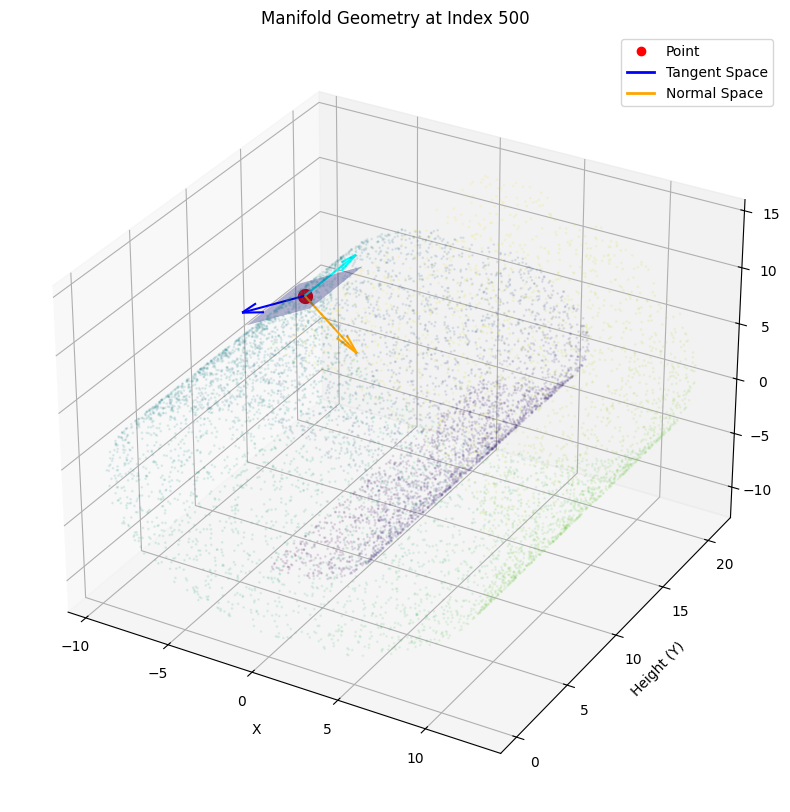

In [23]:
 # Initialize dataset
ds = SwissRollDataset(num_samples=10000) 

# Pick a random sample index to visualize
idx = 500
point = ds[idx]

print(f"Visualizing geometry for point index {idx}...")
print(f"Point coordinates: {point.tolist()}")

# Run the geometry visualization
# This will show the manifold (transparent), the point, 
# the tangent plane (blue patch + arrows), and the normal vector (orange arrow).
ds.visualize_geometry(idx=idx, scale=5.0)

Next let us define a denoiser class. This will host the model that will be trained to predict the noise.

In [24]:
import torch
import torch.nn as nn
import math

class SinusoidalPositionEmbeddings(nn.Module):
    """
    Standard sinusoidal positional embeddings for time steps in diffusion models.
    Conceptually similar to Transformer position encodings.
    """
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        """
        Args:
            time (torch.Tensor): Tensor of shape (batch_size,) containing time steps.
        Returns:
            torch.Tensor: Tensor of shape (batch_size, dim) containing embeddings.
        """
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings

class DenoiseNetwork(nn.Module):
    """
    A simple MLP-based denoising network for 3D data.
    
    It accepts a noisy 3D coordinate and a time step, and outputs the predicted noise.
    This architecture is used for both standard DDPM and the Manifold-Specific noise experiments.
    """
    def __init__(self, data_dim=3, hidden_dim=256, time_dim=64, num_layers=4):
        """
        Args:
            data_dim (int): Dimension of the data (3 for Swiss Roll).
            hidden_dim (int): Number of units in hidden layers.
            time_dim (int): Dimension of the time embedding.
            num_layers (int): Number of hidden layers in the MLP.
        """
        super().__init__()
        
        # Time embedding layer
        self.time_mlp = nn.Sequential(
            SinusoidalPositionEmbeddings(time_dim),
            nn.Linear(time_dim, time_dim),
            nn.SiLU(),
            nn.Linear(time_dim, time_dim),
        )

        # Input projection
        # We concatenate data (3) + time_embedding (time_dim)
        self.input_layer = nn.Sequential(
            nn.Linear(data_dim + time_dim, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.SiLU()
        )

        # Residual MLP Layers
        self.layers = nn.ModuleList([
            nn.Sequential(
                nn.Linear(hidden_dim, hidden_dim),
                nn.SiLU(),
                nn.Linear(hidden_dim, hidden_dim),
                nn.SiLU()
            ) for _ in range(num_layers)
        ])
        
        # Final projection to data dimension (predicting noise)
        self.output_layer = nn.Linear(hidden_dim, data_dim)

    def forward(self, x, t):
        """
        Args:
            x (torch.Tensor): Noisy data batch of shape (Batch, data_dim)
            t (torch.Tensor): Time steps batch of shape (Batch,)
            
        Returns:
            torch.Tensor: Predicted noise of shape (Batch, data_dim)
        """
        # 1. Embed Time
        t_emb = self.time_mlp(t) # (Batch, time_dim)
        
        # 2. Concatenate Input and Time
        # x is (Batch, 3), t_emb is (Batch, 64) -> cat is (Batch, 67)
        x_input = torch.cat([x, t_emb], dim=1)
        
        # 3. Initial Features
        h = self.input_layer(x_input)
        
        # 4. Residual Layers
        for layer in self.layers:
            h = h + layer(h) # Residual connection
            
        # 5. Output Prediction
        return self.output_layer(h)

In [25]:
# Settings
batch_size = 8
data_dim = 3

# Instantiate model
model = DenoiseNetwork(data_dim=data_dim, hidden_dim=128, time_dim=32)
print("Model initialized.")
print(model)

# Create dummy inputs
x_dummy = torch.randn(batch_size, data_dim) # Random noisy points
t_dummy = torch.randint(0, 1000, (batch_size,)) # Random timesteps

# Forward pass
predicted_noise = model(x_dummy, t_dummy)

print(f"\nInput Shape: {x_dummy.shape}")
print(f"Time Shape: {t_dummy.shape}")
print(f"Output Shape: {predicted_noise.shape}")

assert predicted_noise.shape == (batch_size, data_dim), "Output shape mismatch!"
print("\nForward pass successful.")

Model initialized.
DenoiseNetwork(
  (time_mlp): Sequential(
    (0): SinusoidalPositionEmbeddings()
    (1): Linear(in_features=32, out_features=32, bias=True)
    (2): SiLU()
    (3): Linear(in_features=32, out_features=32, bias=True)
  )
  (input_layer): Sequential(
    (0): Linear(in_features=35, out_features=128, bias=True)
    (1): SiLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): SiLU()
  )
  (layers): ModuleList(
    (0-3): 4 x Sequential(
      (0): Linear(in_features=128, out_features=128, bias=True)
      (1): SiLU()
      (2): Linear(in_features=128, out_features=128, bias=True)
      (3): SiLU()
    )
  )
  (output_layer): Linear(in_features=128, out_features=3, bias=True)
)

Input Shape: torch.Size([8, 3])
Time Shape: torch.Size([8])
Output Shape: torch.Size([8, 3])

Forward pass successful.


In [26]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt

class DiffusionExperiment:
    def __init__(self, 
                 num_timesteps=1000, 
                 batch_size=128, 
                 lr=1e-3,
                 mix_ratio = 0.5, 
                 device='cuda' if torch.cuda.is_available() else 'cpu'):
        
        self.device = device
        self.num_timesteps = num_timesteps
        self.batch_size = batch_size
        self.mix_ratio = mix_ratio
        
        # 1. Initialize Dataset and Model
        self.dataset = SwissRollDataset(num_samples=5000)
        self.dataloader = DataLoader(self.dataset, batch_size=batch_size, shuffle=True)
        
        self.model = DenoiseNetwork().to(device)
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)
        self.criterion = nn.MSELoss()
        
        # 2. Define Beta Schedule (Linear schedule as in Ho et al.)
        self.betas = torch.linspace(1e-4, 0.02, num_timesteps).to(device)
        self.alphas = 1.0 - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, dim=0)
        
    def _batch_subspace_noise(self, bases):
        """
        Generates unit-variance Gaussian noise restricted to the subspace defined by 'bases'.
        
        Args:
            bases (torch.Tensor): Shape (B, D, k) where k is subspace dimension.
                                  Assumed to be orthonormal.
        Returns:
            torch.Tensor: Shape (B, D)
        """
        B, D, k = bases.shape
        # Sample z ~ N(0, I) in the subspace coefficient space
        z = torch.randn(B, k, 1, device=self.device)
        
        # Project back to ambient space: noise = Basis * z
        # (B, D, k) @ (B, k, 1) -> (B, D, 1)
        noise = torch.bmm(bases, z).squeeze(2)
        return noise

    def get_mixed_noise(self, x0):
        """
        Generates noise based on the manifold geometry.
        
        Args:
            x0 (torch.Tensor): Original clean data batch (B, 3).
            mix_ratio (float): 0.0 = Standard Isotropic Gaussian.
                               1.0 = Pure Normal Subspace noise.
                               
        Returns:
            torch.Tensor: Generated noise batch.
        """
        # Get bases for the batch
        # We need to transfer x0 to CPU for the dataset methods if they use numpy,
        # but our dataset supports tensor operations, so we keep it on device if possible.
        # However, dataset methods might re-create tensors, so let's just pass the tensors.
        
        tangent_bases = self.dataset.get_tangent_basis(x0) # (B, 3, 2)
        normal_bases = self.dataset.get_normal_basis(x0)   # (B, 3, 1)
        
        # Generate independent noise components
        eps_tan = self._batch_subspace_noise(tangent_bases)
        eps_norm = self._batch_subspace_noise(normal_bases)
        
        # Calculate weights
        # Standard DDPM (mix_ratio=0): 1.0 * Tangent + 1.0 * Normal
        # Manifold Only (mix_ratio=1): 0.0 * Tangent + 1.0 * Normal
        
        w_tan = 1.0 - self.mix_ratio
        w_norm = 1.0
        
        # Combine
        # Note: In standard DDPM, isotropic noise is physically just (tangent_noise + normal_noise)
        # because the bases span the whole space.
        noise = w_tan * eps_tan + w_norm * eps_norm
        
        return noise

    def train_step(self):
        """Performs one epoch of training."""
        self.model.train()
        epoch_loss = 0
        
        for x0 in self.dataloader:
            x0 = x0.to(self.device)
            B = x0.shape[0]
            
            # 1. Sample Time Steps
            t = torch.randint(0, self.num_timesteps, (B,), device=self.device)
            
            # 2. Generate Noise
            # This is where your custom logic happens!
            noise = self.get_mixed_noise(x0)
            
            # 3. Add Noise (Forward Diffusion)
            # x_t = sqrt(alpha_bar) * x0 + sqrt(1 - alpha_bar) * noise
            sqrt_alpha_bar = torch.sqrt(self.alphas_cumprod[t])[:, None]
            sqrt_one_minus_alpha_bar = torch.sqrt(1 - self.alphas_cumprod[t])[:, None]
            
            x_t = sqrt_alpha_bar * x0 + sqrt_one_minus_alpha_bar * noise
            
            # 4. Predict Noise
            predicted_noise = self.model(x_t, t)
            
            # 5. Optimization
            loss = self.criterion(predicted_noise, noise)
            
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            
            epoch_loss += loss.item()
            
        return epoch_loss / len(self.dataloader)

    def sample(self, num_samples=1000):
        """
        Generates samples using the trained model via the reverse process.
        Returns:
            torch.Tensor: Generated samples (N, 3)
        """
        self.model.eval()
        with torch.no_grad():
            # Start from pure noise
            # Note: Sampling usually starts from Isotropic Gaussian even if training was different,
            # though consistent testing might require thinking about this. 
            # For now, we use Standard Gaussian for x_T.
            x = torch.randn(num_samples, 3, device=self.device)
            
            for t_idx in reversed(range(self.num_timesteps)):
                t = torch.full((num_samples,), t_idx, device=self.device, dtype=torch.long)
                
                # Predict noise
                predicted_noise = self.model(x, t)
                
                # Current alpha parameters
                beta_t = self.betas[t_idx]
                alpha_t = self.alphas[t_idx]
                alpha_bar_t = self.alphas_cumprod[t_idx]
                
                # Helper term for mean calculation
                # mu = (1 / sqrt(alpha)) * (x - (beta / sqrt(1 - alpha_bar)) * eps)
                coeff = beta_t / torch.sqrt(1 - alpha_bar_t)
                mean = (1 / torch.sqrt(alpha_t)) * (x - coeff * predicted_noise)
                
                if t_idx > 0:
                    z = torch.randn_like(x)
                    sigma_t = torch.sqrt(beta_t)
                    x = mean + sigma_t * z
                else:
                    x = mean
                    
        return x

    def compute_chamfer_distance(self, samples):
        """
        Computes the Chamfer Distance between generated samples and the true manifold.
        We approximate the true manifold by sampling fresh points from the dataset.
        """
        # Get ground truth samples
        true_samples = self.dataset.data.to(self.device) # (N_true, 3)
        gen_samples = samples.to(self.device)            # (N_gen, 3)
        
        # Pairwise distances
        # We process in chunks to avoid OOM if N is large
        
        # 1. For each gen sample, find closest true sample
        # Simple brute force for demo (optimized libs exist but this is portable)
        # Using a subset for speed if needed
        if len(true_samples) > 2000:
            true_samples = true_samples[:2000]
        if len(gen_samples) > 2000:
            gen_samples = gen_samples[:2000]
            
        # Expansion for broadcasting: (N_gen, 1, 3) - (1, N_true, 3)
        dists = torch.cdist(gen_samples, true_samples) # (N_gen, N_true) L2 distance
        
        dists_sq = dists ** 2
        
        min_dist_gen_to_true, _ = torch.min(dists_sq, dim=1)
        min_dist_true_to_gen, _ = torch.min(dists_sq, dim=0)
        
        chamfer_dist = torch.mean(min_dist_gen_to_true) + torch.mean(min_dist_true_to_gen)
        return chamfer_dist.item()

    def visualize_results(self, samples, title="Generated Samples"):
        """Visualizes generated samples vs ground truth."""
        fig = plt.figure(figsize=(10, 8))
        ax = fig.add_subplot(111, projection='3d')
        
        # Plot Ground Truth (Subset)
        gt_data = self.dataset.data[:1000].cpu().numpy()
        ax.scatter(gt_data[:,0], gt_data[:,1], gt_data[:,2], 
                   c='gray', alpha=0.1, s=2, label='Ground Truth')
        
        # Plot Generated
        gen_data = samples.cpu().numpy()
        ax.scatter(gen_data[:,0], gen_data[:,1], gen_data[:,2], 
                   c='blue', alpha=0.6, s=2, label='Generated')
        
        ax.set_title(title)
        ax.legend()
        plt.show()

Starting Diffusion Experiment...
Training with Noise Mix Ratio: 0.75
Epoch 0: Loss 0.375323
Epoch 10: Loss 0.329015
Epoch 20: Loss 0.265227
Epoch 30: Loss 0.235472
Epoch 40: Loss 0.200157
Epoch 50: Loss 0.160107
Epoch 60: Loss 0.148450
Epoch 70: Loss 0.153311
Epoch 80: Loss 0.148914
Epoch 90: Loss 0.154648

Generating samples...
Chamfer Distance (Lower is better): 86.508240


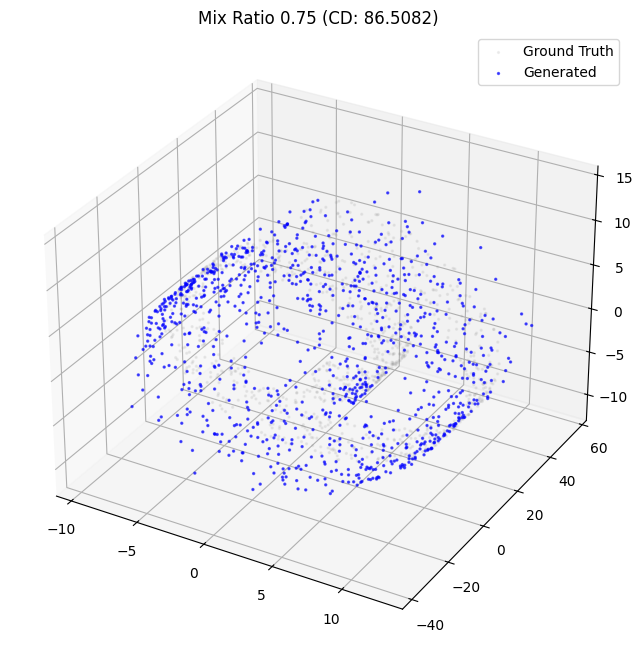

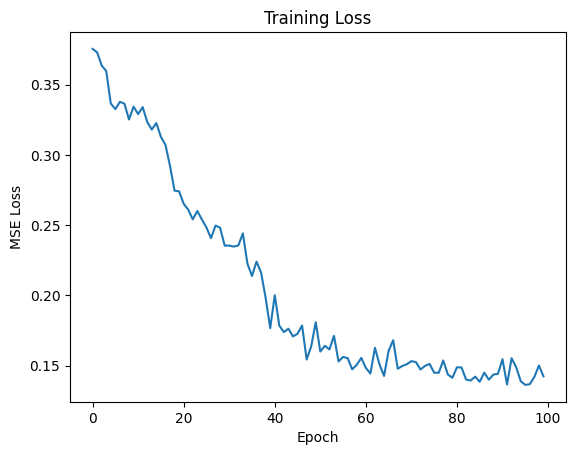

In [28]:
print("Starting Diffusion Experiment...")
    
# Configuration
# mix_ratio: 0.0 = Standard DDPM, 0.75 = Mostly Normal Noise
MIX_RATIO = 0.75 
EPOCHS = 100 # Reduced for quick demo, increase for real results

experiment = DiffusionExperiment(num_timesteps=500, batch_size=256, mix_ratio=MIX_RATIO)

loss_history = []
print(f"Training with Noise Mix Ratio: {MIX_RATIO}")

for epoch in range(EPOCHS):
    loss = experiment.train_step()
    loss_history.append(loss)
    if epoch % 10 == 0:
        print(f"Epoch {epoch}: Loss {loss:.6f}")
        
# Generate and Evaluate
print("\nGenerating samples...")
generated_samples = experiment.sample(num_samples=1000)

cd_score = experiment.compute_chamfer_distance(generated_samples)
print(f"Chamfer Distance (Lower is better): {cd_score:.6f}")

# Visualize
experiment.visualize_results(generated_samples, title=f"Mix Ratio {MIX_RATIO} (CD: {cd_score:.4f})")

# Optional: Plot Loss
plt.figure()
plt.plot(loss_history)
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.show()

Starting Diffusion Experiment...
Training with Noise Mix Ratio: 0.25
Epoch 0: Loss 0.718218
Epoch 10: Loss 0.611177
Epoch 20: Loss 0.585464
Epoch 30: Loss 0.550818
Epoch 40: Loss 0.528110
Epoch 50: Loss 0.511107
Epoch 60: Loss 0.458400
Epoch 70: Loss 0.437648
Epoch 80: Loss 0.437939
Epoch 90: Loss 0.434553

Generating samples...
Chamfer Distance (Lower is better): 1.207135


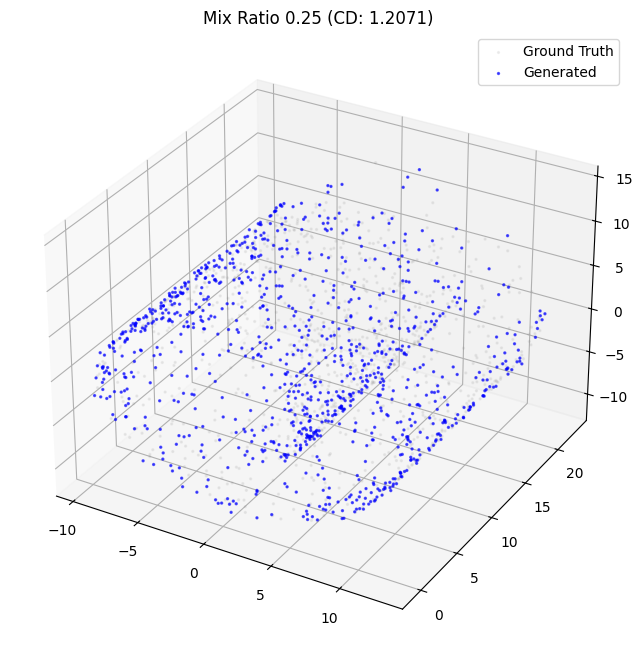

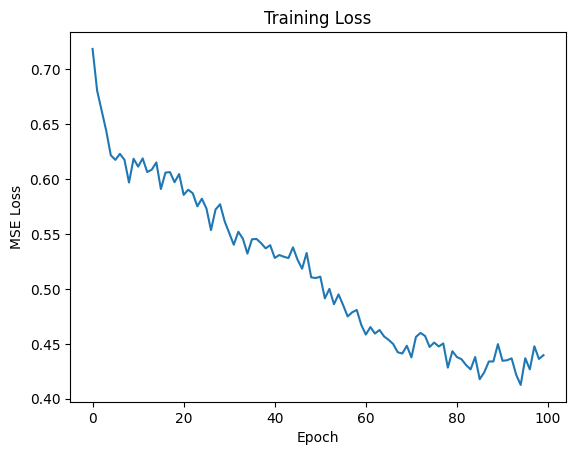

In [29]:
print("Starting Diffusion Experiment...")
    
# Configuration
# mix_ratio: 0.0 = Standard DDPM, 0.75 = Mostly Normal Noise
MIX_RATIO = 0.25 
EPOCHS = 100 # Reduced for quick demo, increase for real results

experiment = DiffusionExperiment(num_timesteps=500, batch_size=256, mix_ratio=MIX_RATIO)

loss_history = []
print(f"Training with Noise Mix Ratio: {MIX_RATIO}")

for epoch in range(EPOCHS):
    loss = experiment.train_step()
    loss_history.append(loss)
    if epoch % 10 == 0:
        print(f"Epoch {epoch}: Loss {loss:.6f}")
        
# Generate and Evaluate
print("\nGenerating samples...")
generated_samples = experiment.sample(num_samples=1000)

cd_score = experiment.compute_chamfer_distance(generated_samples)
print(f"Chamfer Distance (Lower is better): {cd_score:.6f}")

# Visualize
experiment.visualize_results(generated_samples, title=f"Mix Ratio {MIX_RATIO} (CD: {cd_score:.4f})")

# Optional: Plot Loss
plt.figure()
plt.plot(loss_history)
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.show()

Starting Diffusion Experiment...
Training with Noise Mix Ratio: 0.0
Epoch 0: Loss 0.993098
Epoch 10: Loss 0.818638
Epoch 20: Loss 0.812361
Epoch 30: Loss 0.766797
Epoch 40: Loss 0.729881
Epoch 50: Loss 0.735990
Epoch 60: Loss 0.687680
Epoch 70: Loss 0.680660
Epoch 80: Loss 0.666900
Epoch 90: Loss 0.644976

Generating samples...
Chamfer Distance (Lower is better): 1.270787


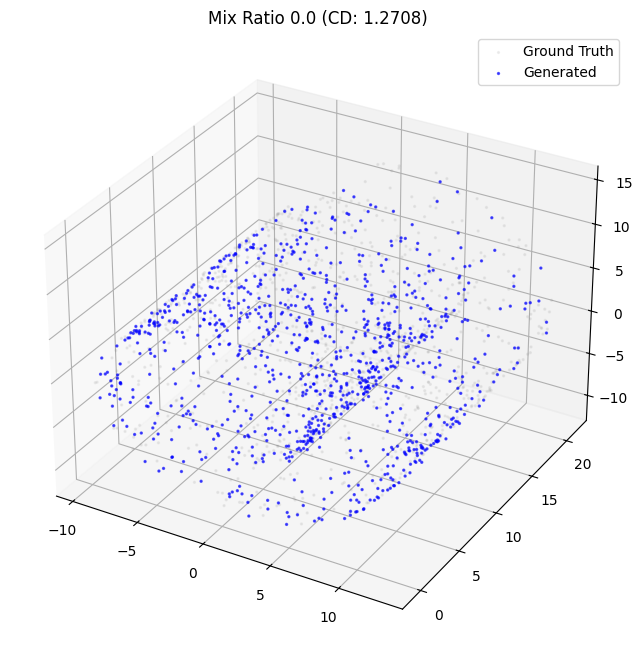

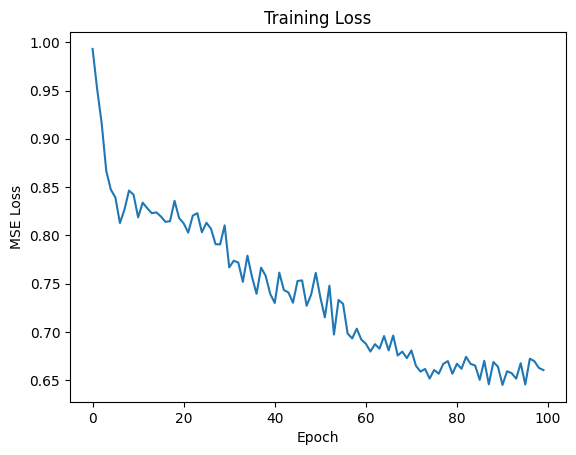

In [30]:
print("Starting Diffusion Experiment...")
    
# Configuration
# mix_ratio: 0.0 = Standard DDPM, 0.75 = Mostly Normal Noise
MIX_RATIO = 0.0 
EPOCHS = 100 # Reduced for quick demo, increase for real results

experiment = DiffusionExperiment(num_timesteps=500, batch_size=256, mix_ratio=MIX_RATIO)

loss_history = []
print(f"Training with Noise Mix Ratio: {MIX_RATIO}")

for epoch in range(EPOCHS):
    loss = experiment.train_step()
    loss_history.append(loss)
    if epoch % 10 == 0:
        print(f"Epoch {epoch}: Loss {loss:.6f}")
        
# Generate and Evaluate
print("\nGenerating samples...")
generated_samples = experiment.sample(num_samples=1000)

cd_score = experiment.compute_chamfer_distance(generated_samples)
print(f"Chamfer Distance (Lower is better): {cd_score:.6f}")

# Visualize
experiment.visualize_results(generated_samples, title=f"Mix Ratio {MIX_RATIO} (CD: {cd_score:.4f})")

# Optional: Plot Loss
plt.figure()
plt.plot(loss_history)
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.show()